### Элементарные алгоритмы обработки временных рядов

Взять из прошлого домашнего задания ряд (в двух вариантах - стаицонарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображение почему была выбрана та или иная модель.

Загрузим необходимые библиотеки:

In [1]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline

Загрузим исходный ряд:

In [2]:
auto_registration = pd.read_csv("homework_monthly-us-auto-registration-tho.csv",sep=';')

Посмотрим, как выглядят наш нестанционарный ряд:

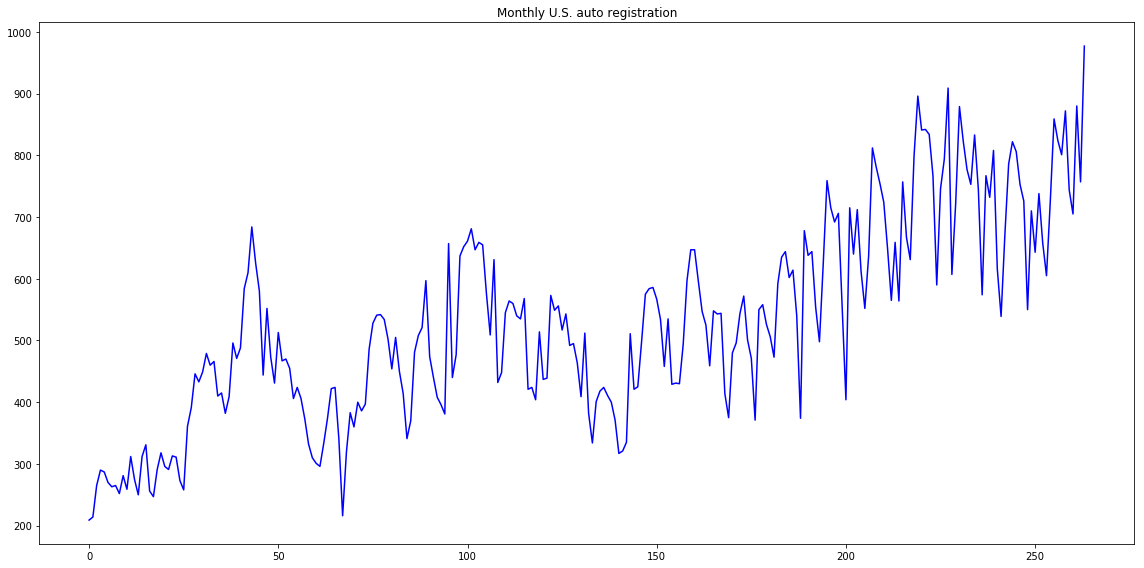

In [3]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
auto_registration["Count"].plot(ax=ts_ax, color='blue')
ts_ax.set_title("Monthly U.S. auto registration")
plt.tight_layout()

Разделим ряд на train и test, как 80% и 20% соответственно

In [4]:
int(auto_registration.shape[0]*0.8)

211

In [138]:
train = auto_registration[0:211]
test = auto_registration[210:]

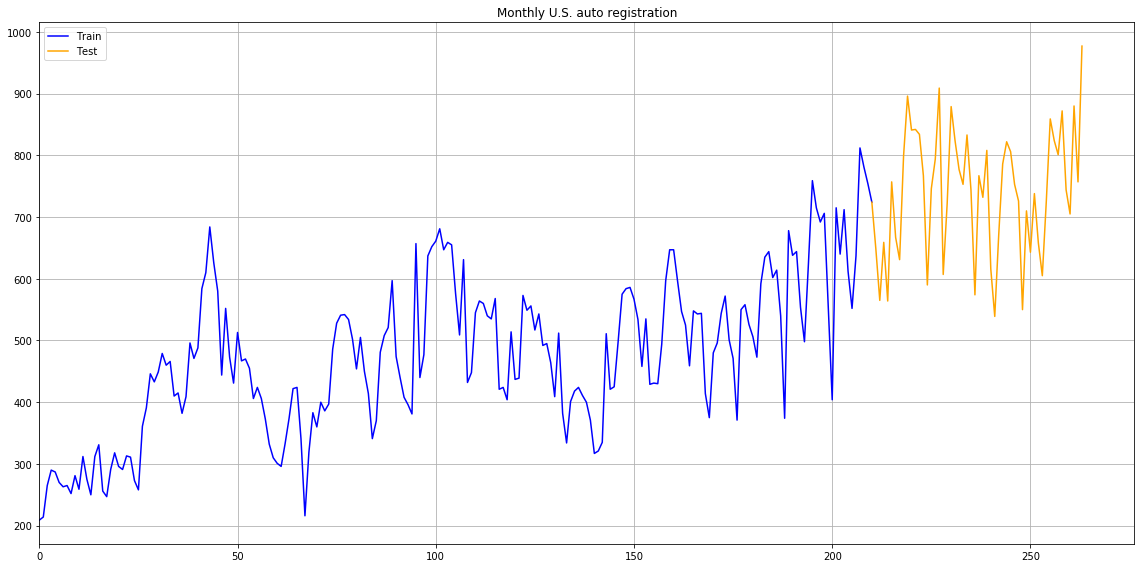

In [139]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
train.plot(ax=ts_ax, color='blue')
test.plot(ax=ts_ax, color='orange')
ts_ax.set_title("Monthly U.S. auto registration")
plt.legend(['Train',"Test"])
plt.grid(True)
plt.xlim(0)
plt.tight_layout()

Здесь есть тренд и сезонность, поэтому сразу применим Holt-Winter's метод, который учитывает компоненту сезнности и тренда.

In [140]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [141]:
def initial_trend(series, season_len):
    sum=0.0
    for i in range(season_len):
        sum+=float(series[i+season_len]-series[i]) / season_len
    return sum / season_len

In [142]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [143]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [164]:
def plot_tema(alpha, beta, gamma, ser, test, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    plt.figure(figsize=(14, 8))
    plt.plot(ser, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA')
    plt.plot(test, color='orange', linewidth='2', label='original_test')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.grid(True)
    plt.legend()

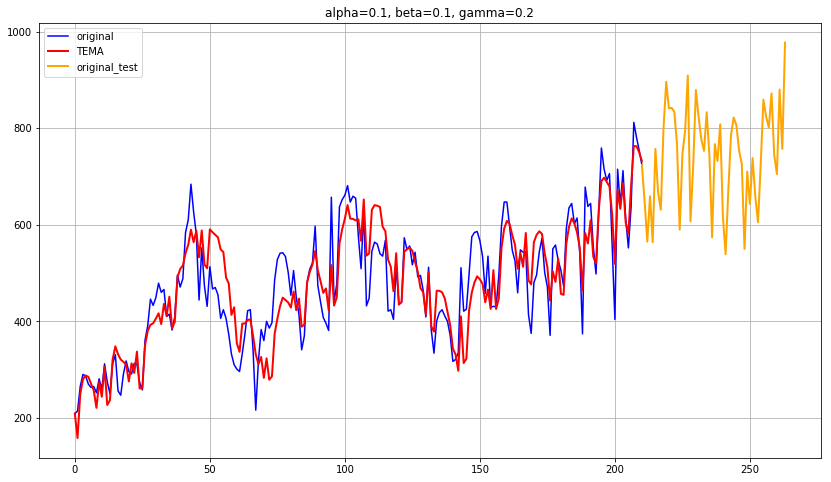

In [165]:
plot_tema(0.1, 0.1, 0.2,train['Count'],test['Count'] ,0)

Подберем оптимальные коэффициенты alpha, beta, gamma

In [166]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [167]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0.1, 0.9), (0.1, 0.9), (0.1, 0.9)))

In [168]:
alpha, beta, gamma =opt.x 

In [169]:
alpha, beta, gamma

(0.1, 0.21836378040892496, 0.8577850734187721)

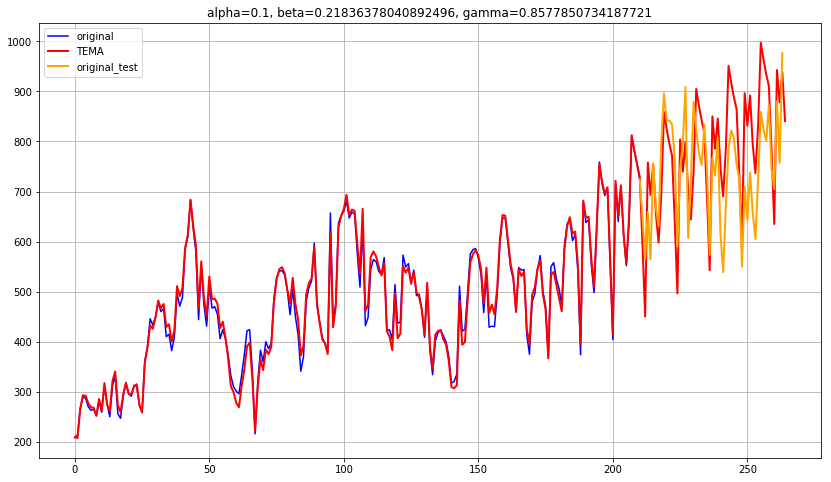

In [171]:
plot_tema(alpha, beta, gamma,train['Count'],test['Count'] ,len(test['Count']))

In [173]:
tema = triple_exponential_smoothing(train['Count'], 12, alpha, beta, gamma, len(test['Count']))

In [192]:
error = mean_squared_error(tema[-len(test):], test.Count)
print("MSE = {}".format(error))

MSE = 22481.395336063713


## Стационарный ряд

Сделаем ряд стационарным

In [18]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [19]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Построим график автокорреляции и частичной автокорреляции:

In [20]:
series_auto_registration = auto_registration['Count'] 
series_auto_registration = boxcox(series_auto_registration, 0)
series_auto_registration = series_auto_registration[1:] - series_auto_registration[:-1]
series_auto_registration = series_auto_registration[12:] - series_auto_registration[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


D:\Netology\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


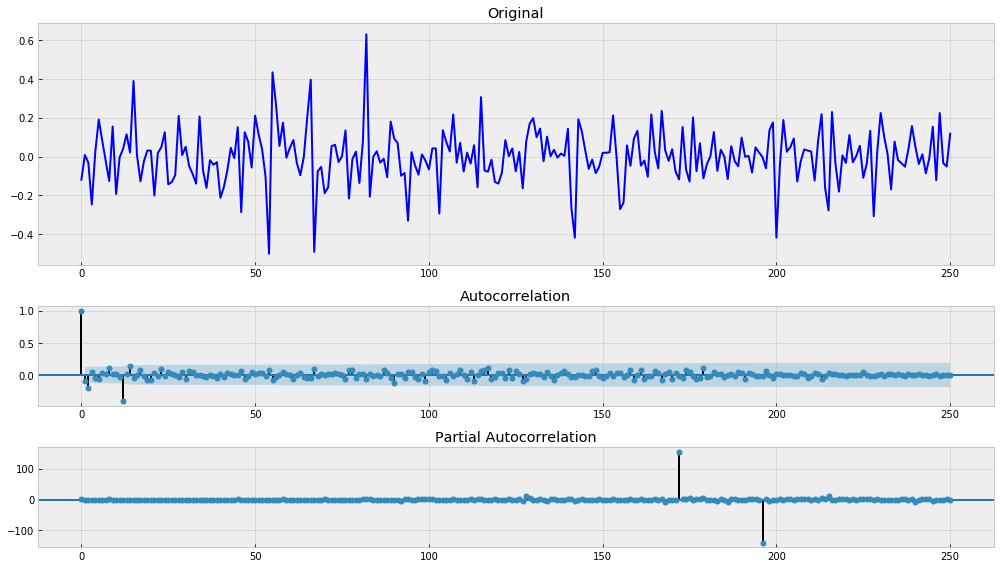

In [21]:
tsplot(series_auto_registration)

Разделим ряд на train и test, как 80% и 20% соответственно

In [22]:
series_auto_registration_df=pd.DataFrame(series_auto_registration)
series_auto_registration_df.columns=["Count"]
series_auto_registration_df.index=range(0,series_auto_registration_df.shape[0])
train = series_auto_registration_df[0:200]
test = series_auto_registration_df[199:]

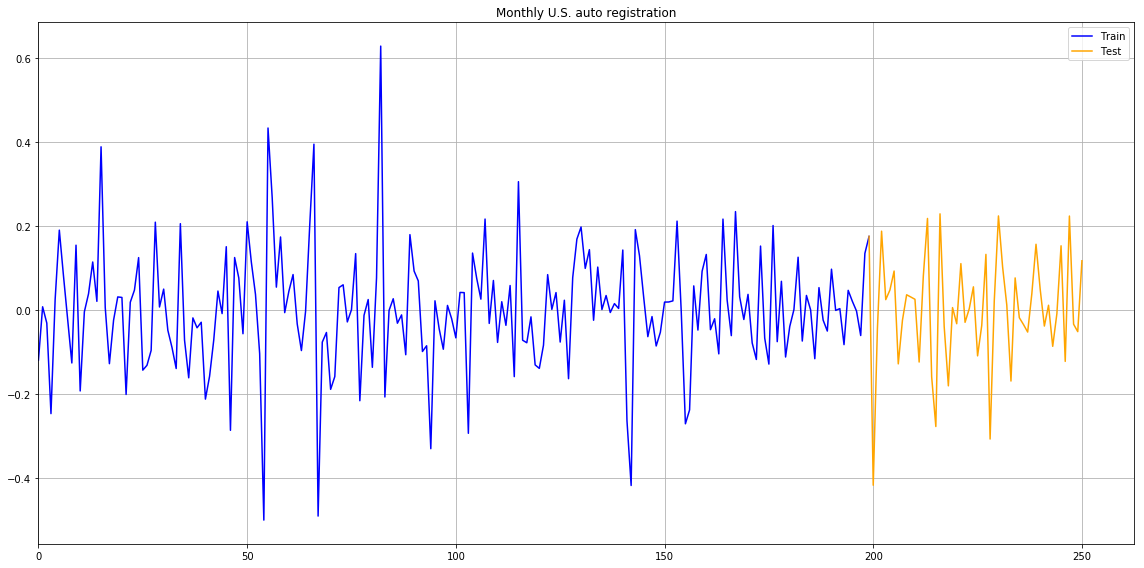

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(train["Count"], color='blue')
plt.plot(test["Count"], color='orange')
plt.title("Monthly U.S. auto registration")
plt.legend(['Train',"Test"])
plt.grid(True)
plt.xlim(0)
plt.tight_layout()

В данном ряде нет ни тренда ни сезонности, можно применить более простые методы ma, wma, ema.

### MA

In [24]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [25]:
ser = moving_average(train["Count"], 7)

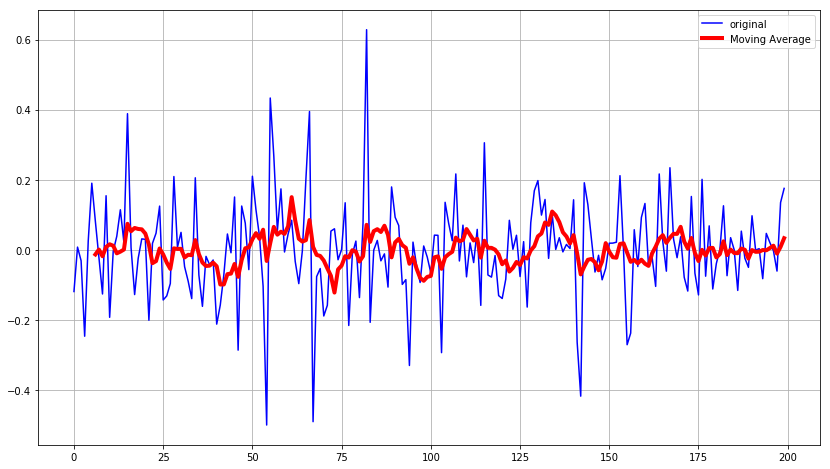

In [26]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(ser, color='red', linewidth='4', label='Moving Average')
plt.grid(True)
plt.legend()

Предскажем значения для test  посчитаем mse (оценим качество).

In [27]:
def ma_predict(series,window,n):  
    predict_s = series.copy()
    for _ in range(0,n):        
        predict_s.loc[predict_s.index[-1]+1]=predict_s[-window:].mean()        
    return predict_s

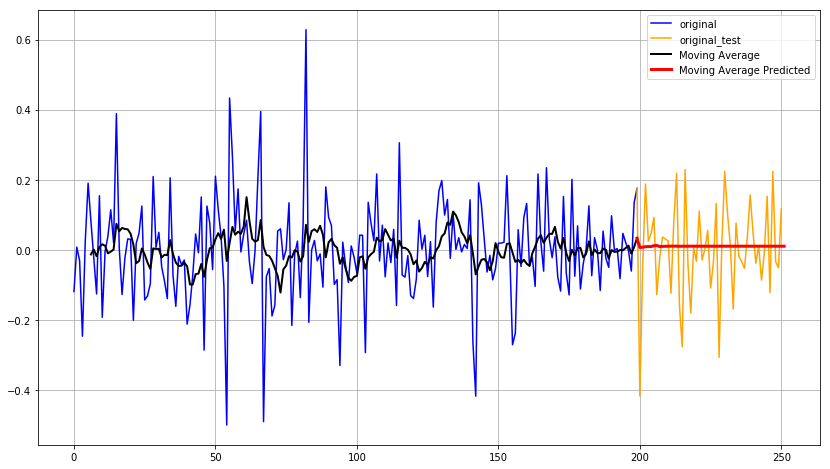

In [28]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(test["Count"], color='orange',label='original_test')
plt.plot(ser, color='black', linewidth='2', label='Moving Average')
plt.plot(ma_predict(ser,7,len(test))[-len(test)-1:], color='red', linewidth='3', label='Moving Average Predicted')
plt.grid(True)
plt.legend()

С увеличением значения window мы будем полуать более сглаженный тренд

In [29]:
error = mean_squared_error(ma_predict(ser,7,len(test))[-len(test):], test)
print("MSE = {}".format(error))

MSE = 0.01766798312516286


### WMA

In [30]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [31]:
ser = weighted_moving_average(train["Count"], 7,[1,2,4,8,16,32,64])

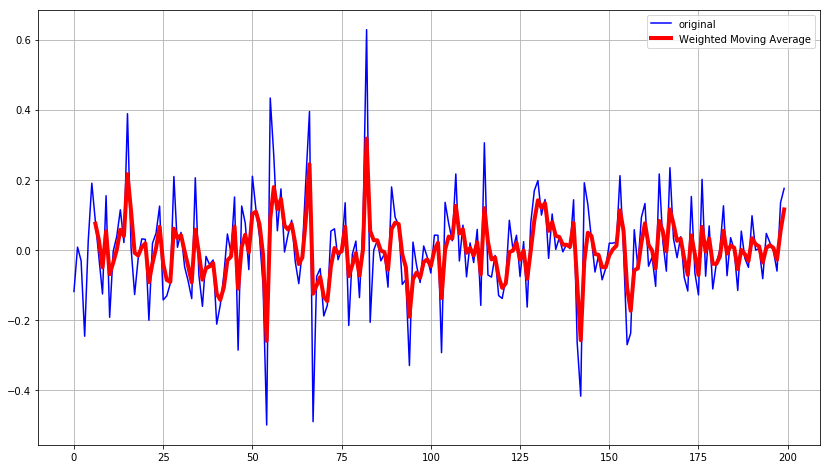

In [32]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(ser, color='red', linewidth='4', label='Weighted Moving Average')
plt.grid(True)
plt.legend()

Предскажем значения для test  посчитаем mse (оценим качество).

In [33]:
def wma_predict(series,window,n,weights):  
    predict_s = series.copy()
    for _ in range(0,n):        
        predict_s.loc[predict_s.index[-1]+1]=(predict_s[-window:]*weights).sum() / sum(weights)        
    return predict_s

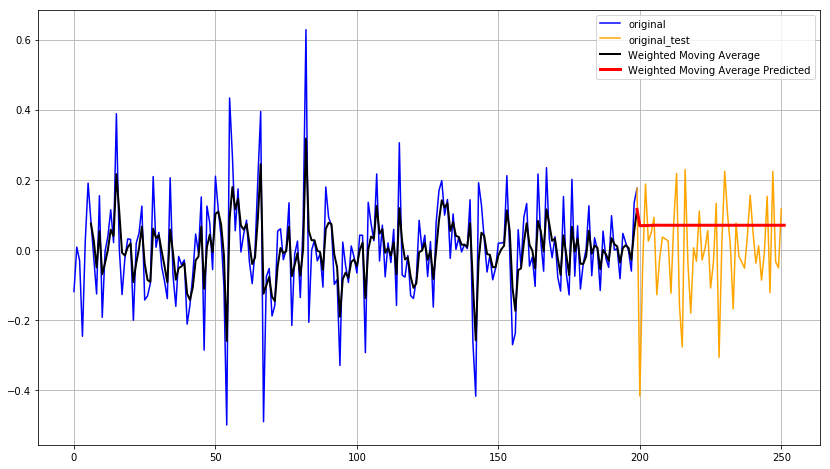

In [34]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(test["Count"], color='orange',label='original_test')
plt.plot(ser, color='black', linewidth='2', label='Weighted Moving Average')
plt.plot(wma_predict(ser,7,len(test),[1,2,4,8,16,32,64])[-len(test)-1:], color='red', linewidth='3', label='Weighted Moving Average Predicted')
plt.grid(True)
plt.legend()

In [35]:
error = mean_squared_error(wma_predict(ser,7,len(test),[1,2,4,8,16,32,64])[-len(test):], test)
print("MSE = {}".format(error))

MSE = 0.02221651572768577


### EMA

In [82]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [83]:
ser = exponential_moving_average(train["Count"], 0.7)

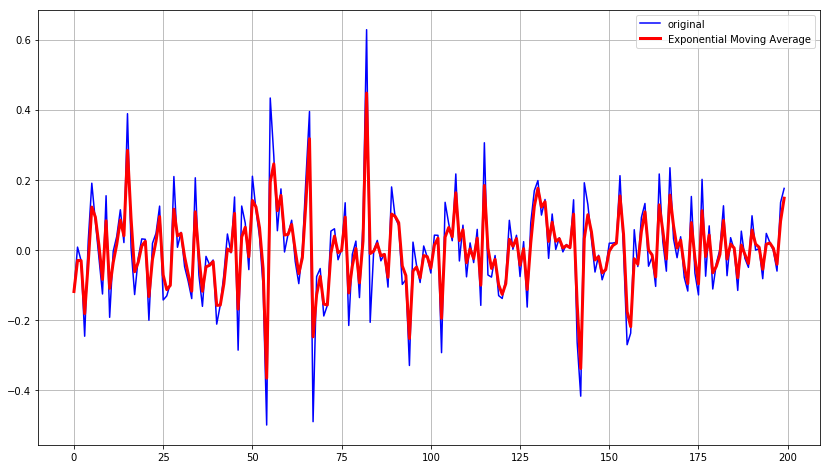

In [84]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(ser, color='red', linewidth='3', label='Exponential Moving Average')
#plt.plot(ser1, color='green', linewidth='3', label='Exponential Moving Average')
plt.grid(True)
plt.legend()

In [133]:
def exponential_predict(series, alpha, n_pred=None):      
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])   
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True)

[0.14735452133896407] 0.17533613800353542 0.0820640824549643


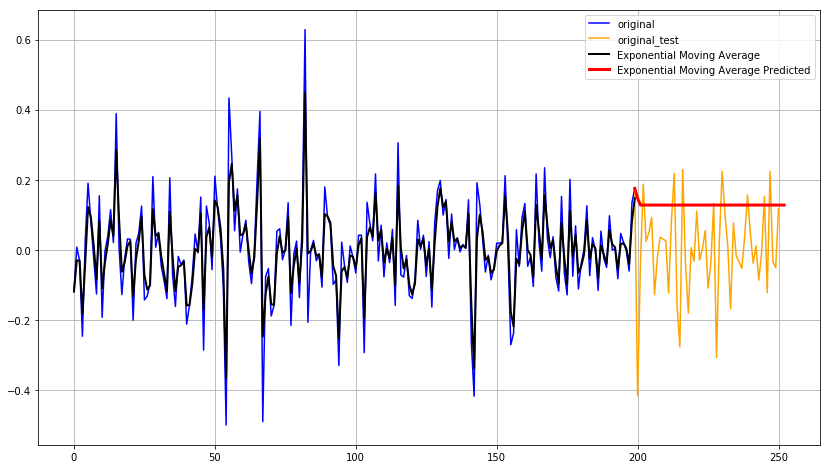

In [131]:
plt.figure(figsize=(14, 8))
plt.plot(train["Count"], color='blue',label='original')
plt.plot(test["Count"], color='orange',label='original_test')
plt.plot(ser, color='black', linewidth='2', label='Exponential Moving Average')
plt.plot(exponential_predict(train["Count"],0.7,len(test))[-len(test)-2:], color='red', linewidth='3', label='Exponential Moving Average Predicted')
plt.grid(True)
plt.legend()

In [136]:
error = mean_squared_error(exponential_predict(train["Count"],0.2,len(test))[-len(test):], test)
print("MSE = {}".format(error))

MSE = 0.018142052311023893
